# Генерация данных по резервам

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import catboost

pd.options.display.max_columns = 1000

In [2]:
def catboost_save_dataset(X, y, path):
    Y = pd.DataFrame({'__target__': y})
    Y.index = X.index
    dataset = pd.concat([Y, X], axis=1)
    dataset.to_csv(path, sep='\t', header=False, index=False)


def catboost_save_columns(columns, cat_features, path):
    file = open(path, "w")
    file.write('0\tTarget')
    for index, is_cat in enumerate(columns.isin(cat_features), 1):
        file.write('\n{0}\t{1}'.format(index, 'Categ' if is_cat else 'Auxiliary'))


def catboost_save(X_train, X_test, y_train, y_test, cat_features, train_path, test_path, columns_path):
    catboost_save_dataset(X_train, y_train, train_path)
    catboost_save_dataset(X_test, y_test, test_path)
    catboost_save_columns(pd.Series(list(X_train)), cat_features, columns_path)

In [3]:
def build_reserve_all(air_reserve, hpg_reserve):
    columns = ['visit_datetime', 'reserve_visitors', 'city']
    reserve_all = pd.concat([air_reserve[columns], hpg_reserve[columns]])
    
    reserve_all['visit_datetime'] = pd.to_datetime(reserve_all['visit_datetime'])
    reserve_all['visit_date']     = reserve_all['visit_datetime'].dt.strftime('%Y-%m-%d')

    reserve_all = reserve_all.groupby(['visit_date', 'city'], as_index=False)[['reserve_visitors']].sum()
    reserve_all = reserve_all.rename(columns={'reserve_visitors': 'reserve_visitors_all'})
    
    return reserve_all


def draw_reserve_all(reserve_all, date_range=pd.date_range('2016-01-01', '2017-05-31')):
    reserve_all \
        [pd.to_datetime(reserve_all['visit_date']).isin(date_range)] \
        .groupby(['visit_date'])[['reserve_visitors_all']].sum() \
        .plot(figsize=(18,10))
    pyplot.show()

In [4]:
def build_reserve(air_reserve, stores_dates, reserve_all):
    columns = ['air_store_id', 'visit_datetime', 'reserve_visitors', 'city']
    reserve = air_reserve[columns].copy()
    
    reserve['visit_datetime'] = pd.to_datetime(reserve['visit_datetime'])
    reserve['visit_date']     = reserve['visit_datetime'].dt.strftime('%Y-%m-%d')
    
    reserve = reserve.groupby(['air_store_id', 'visit_date'], as_index=False)[['reserve_visitors']].sum()
    
    reserve = pd.merge(stores_dates, reserve, how='left', on=['air_store_id', 'visit_date'])
    reserve = pd.merge(reserve, reserve_all, how='left', on=['visit_date', 'city'])
    reserve = reserve.fillna(0)
    reserve['reserve_visitors_competitor'] = reserve['reserve_visitors_all'] - reserve['reserve_visitors']
    
    return reserve

In [5]:
def conv_reserve_to_air(reserve):
    air_reserve = reserve[['air_store_id', 'reserve_visitors', 'visit_datetime', 'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'city']].copy()
    return air_reserve

In [6]:
data = {
    'air_reserve': pd.read_csv('dataset/air_reserve.csv'),
    'hpg_reserve': pd.read_csv('dataset/hpg_reserve.csv'),
    'air_hpg':     pd.read_csv('dataset/store_id_relation.csv'),
    'cities':      pd.read_csv('dataset/cities.csv'),
    
    'air_stores': pd.read_csv('result/air_stores.csv'),
    'hpg_stores': pd.read_csv('result/hpg_stores.csv'),
    'dates':      pd.read_csv('result/dates.csv'),
}

### Подготавливаем `air_reserve` и `hpg_reserve`

 Расширяем `air_reserve` данными из `hpg_reserve`

In [7]:
data['hpg_reserve'] = pd.merge(data['hpg_reserve'], data['air_hpg'], how='left', on=['hpg_store_id'])
data['air_reserve'] = pd.concat([data['air_reserve'], data['hpg_reserve'].drop('hpg_store_id', axis=1).dropna()])

Удаляем дублирующие `air_reserve` записи из `hpg_reserve`

In [8]:
data['hpg_reserve'] = data['hpg_reserve'][data['hpg_reserve'].isnull()['air_store_id']].drop('air_store_id', axis=1)

In [9]:
data['air_reserve'] = pd.merge(data['air_reserve'], data['air_stores'], how='inner', on=['air_store_id'])
data['hpg_reserve'] = pd.merge(data['hpg_reserve'], data['hpg_stores'], how='inner', on=['hpg_store_id'])

In [10]:
data['air_reserve'] = data['air_reserve'].drop('reserve_datetime', axis=1)
data['hpg_reserve'] = data['hpg_reserve'].drop('reserve_datetime', axis=1)

In [11]:
print('air_reserve', data['air_reserve'].shape)
print('hpg_reserve', data['hpg_reserve'].shape)

air_reserve (120561, 8)
hpg_reserve (857780, 8)


### Обрабатываем список ресторанов и дат

In [12]:
stores_id = data['air_stores']['air_store_id']
data['stores_dates'] = pd.concat(
    [pd.DataFrame({
        'air_store_id': stores_id,
        'visit_date':   [visit_date] * len(stores_id),
    }) for visit_date in data['dates']['visit_date']],
    axis=0,
    ignore_index=True,
).reset_index(drop=True)

In [13]:
data['stores_dates'] = pd.merge(data['stores_dates'], data['dates'], how='left', on=['visit_date'])
data['stores_dates'] = pd.merge(data['stores_dates'], data['air_stores'], how='left', on=['air_store_id'])
data['stores_dates']['visit_datetime'] = pd.to_datetime(data['stores_dates']['visit_date'])

In [14]:
print('stores_dates', data['stores_dates'].shape)

data['stores_dates'].head()

stores_dates (428593, 16)


,air_store_id,visit_date,visit_holiday,visit_day,visit_month,visit_year,visit_dow,visit_work,visit_weekend,visit_date_int,air_genre_name,air_area_name,latitude,longitude,city,visit_datetime
0,air_0f0cdeee6c9bf3d7,2016-01-01,1,1,1,2016,4,True,False,20160101,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,2016-01-01
1,air_7cc17a324ae5c7dc,2016-01-01,1,1,1,2016,4,True,False,20160101,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,2016-01-01
2,air_fee8dcf4d619598e,2016-01-01,1,1,1,2016,4,True,False,20160101,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,2016-01-01
3,air_a17f0778617c76e2,2016-01-01,1,1,1,2016,4,True,False,20160101,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,2016-01-01
4,air_83db5aff8f50478e,2016-01-01,1,1,1,2016,4,True,False,20160101,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo,2016-01-01


### Формируем `reserve_all` и `reserve`

In [15]:
data['reserve_all'] = build_reserve_all(data['air_reserve'], data['hpg_reserve'])
data['reserve']     = build_reserve(data['air_reserve'], data['stores_dates'], data['reserve_all'])

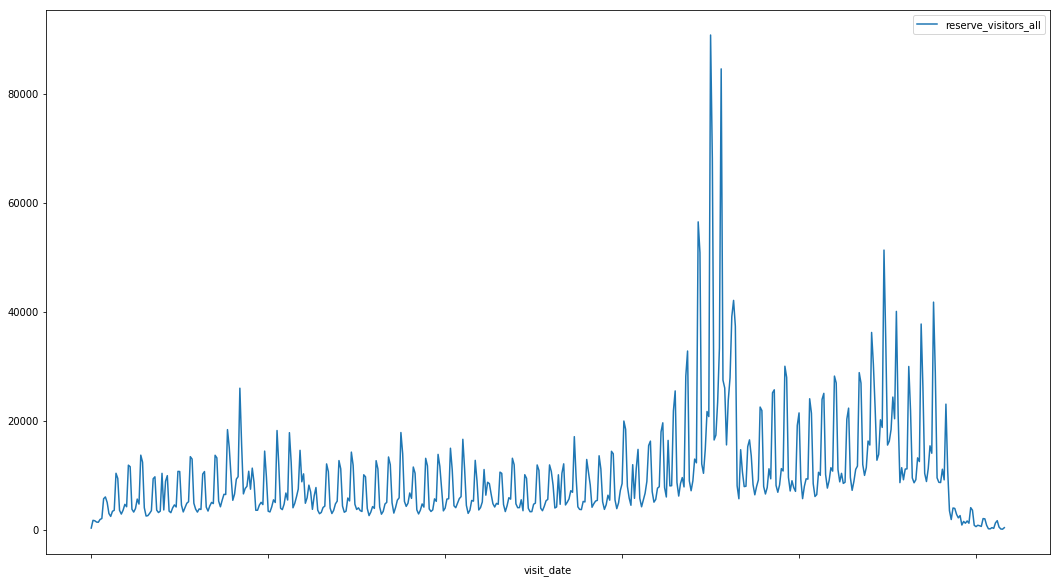

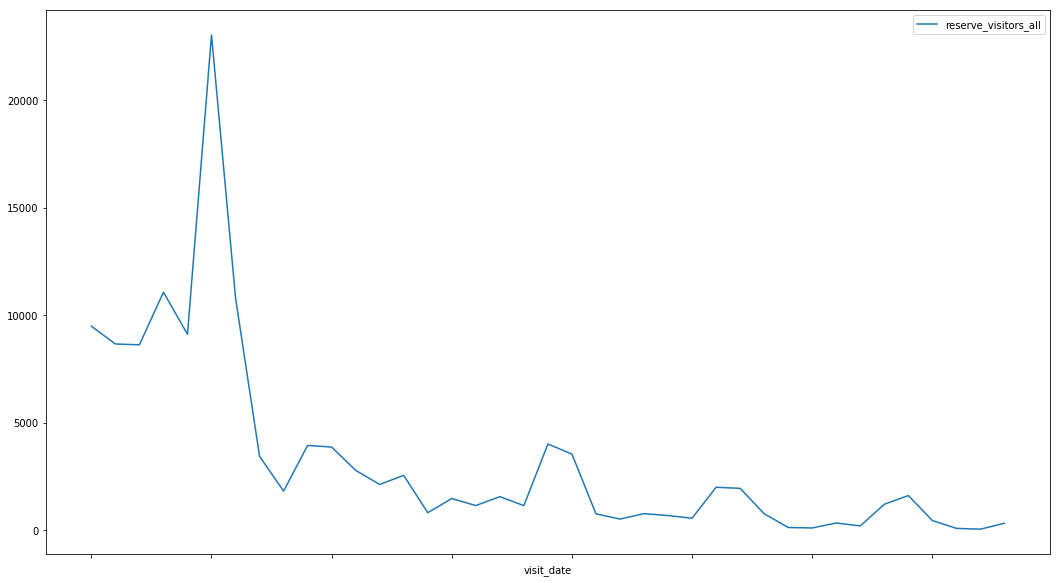

In [16]:
draw_reserve_all(data['reserve_all'])
draw_reserve_all(data['reserve_all'], pd.date_range('2017-04-23', '2017-05-31'))

### Предсказываем `reserve` для периода `2017-04-23` - `2017-05-31`

In [17]:
columns_index          = ['air_store_id', 'visit_day', 'visit_month']
columns_left_data      = ['air_genre_name', 'air_area_name', 'latitude', 'longitude', 'city']
columns_left_extra     = ['visit_datetime', 'reserve_visitors']
columns_both_data      = ['visit_holiday', 'visit_dow', 'visit_work', 'visit_weekend']
columns_both_data_old  = list(map(lambda name: name + '_old', columns_both_data))
columns_right_data     = ['reserve_visitors', 'reserve_visitors_all', 'reserve_visitors_competitor']
columns_right_data_old = list(map(lambda name: name + '_old', columns_right_data))

reserve_new = data['reserve'][data['reserve']['visit_year'] == 2017][columns_index + columns_left_data + columns_both_data + columns_left_extra]

reserve_old = data['reserve'][data['reserve']['visit_year'] == 2016][columns_index + columns_both_data + columns_right_data]
reserve_old.columns = columns_index + columns_both_data_old + columns_right_data_old

reserve = pd.merge(reserve_new, reserve_old, how='left', on=columns_index)

train  = reserve[reserve['visit_datetime'].isin(pd.date_range('2017-01-01', '2017-04-22'))].copy()
result = reserve[reserve['visit_datetime'].isin(pd.date_range('2017-04-23', '2017-05-31'))].copy()

In [18]:
train.head()

,air_store_id,visit_day,visit_month,air_genre_name,air_area_name,latitude,longitude,city,visit_holiday,visit_dow,visit_work,visit_weekend,visit_datetime,reserve_visitors,visit_holiday_old,visit_dow_old,visit_work_old,visit_weekend_old,reserve_visitors_old,reserve_visitors_all_old,reserve_visitors_competitor_old
0,air_0f0cdeee6c9bf3d7,1,1,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,4,6,False,True,2017-01-01,0.0,1,4,True,False,0.0,62.0,62.0
1,air_7cc17a324ae5c7dc,1,1,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,4,6,False,True,2017-01-01,0.0,1,4,True,False,0.0,62.0,62.0
2,air_fee8dcf4d619598e,1,1,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,4,6,False,True,2017-01-01,0.0,1,4,True,False,0.0,62.0,62.0
3,air_a17f0778617c76e2,1,1,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,4,6,False,True,2017-01-01,0.0,1,4,True,False,0.0,62.0,62.0
4,air_83db5aff8f50478e,1,1,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo,4,6,False,True,2017-01-01,0.0,1,4,True,False,0.0,105.0,105.0


In [19]:
columns = pd.Series(columns_index + columns_left_data + columns_both_data + columns_both_data_old + columns_right_data_old)
cat_features = [
    'air_store_id',
    'visit_day',
    'visit_month',
    'air_genre_name',
    'air_area_name',
    'city',
    'visit_holiday',
    'visit_dow',
    'visit_work',
    'visit_weekend',
    'visit_holiday_old',
    'visit_dow_old',
    'visit_work_old',
    'visit_weekend_old',
]

Catboost на GPU отказывается учиться, если не убрать колонки `air_store_id`, `visit_dow`

In [20]:
columns = columns[- columns.isin(['air_store_id', 'visit_dow'])]

columns

1                           visit_day
2                         visit_month
3                      air_genre_name
4                       air_area_name
5                            latitude
6                           longitude
7                                city
8                       visit_holiday
10                         visit_work
11                      visit_weekend
12                  visit_holiday_old
13                      visit_dow_old
14                     visit_work_old
15                  visit_weekend_old
16               reserve_visitors_old
17           reserve_visitors_all_old
18    reserve_visitors_competitor_old
dtype: object

In [21]:
X_all = train[columns]
y_all = np.log1p(train['reserve_visitors'])

stratify = np.clip(train['reserve_visitors'], a_min=0, a_max=40)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2, 
    random_state=78235,
    stratify=stratify,
)

In [22]:
train_path   = 'catboost/reserve/train.tsv'
test_path    = 'catboost/reserve/test.tsv'
result_path  = 'catboost/reserve/result.tsv'
columns_path = 'catboost/reserve/columns.cd'
model_path   = 'catboost/reserve/model.bin'

In [23]:
catboost_save(X_train, X_test, y_train, y_test, cat_features, train_path, test_path, columns_path)

In [24]:
model = catboost.CatBoostRegressor()
model.load_model(model_path)

In [25]:
catboost_save_dataset(result[columns], [0] * len(result), result_path)
result_pool = catboost.Pool(result_path, column_description=columns_path)
result_preds = model.predict(result_pool)
result['reserve_visitors'] = np.clip(np.expm1(result_preds), a_min=0, a_max=10000)

Пересчитываем `air_reserve`, `reserve_all`, `reserve`

In [26]:
reserve_2016 = data['reserve'][data['reserve']['visit_datetime'].isin(pd.date_range('2016-01-01', '2016-12-31'))]

data['air_reserve'] = pd.concat([conv_reserve_to_air(reserve_2016), conv_reserve_to_air(train), conv_reserve_to_air(result)])
data['reserve_all'] = build_reserve_all(data['air_reserve'], data['hpg_reserve'])
data['reserve']     = build_reserve(data['air_reserve'], data['stores_dates'], data['reserve_all'])

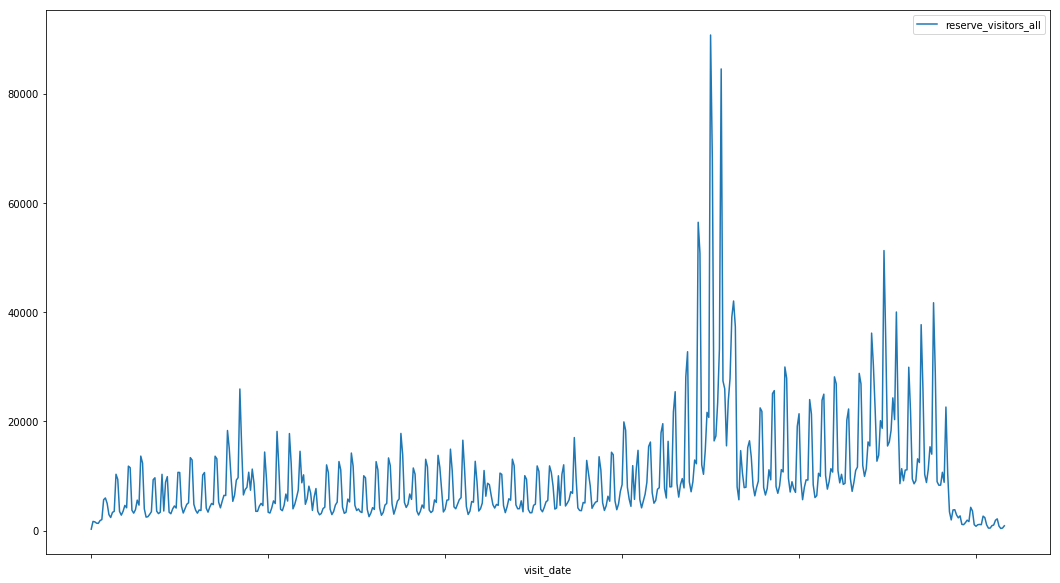

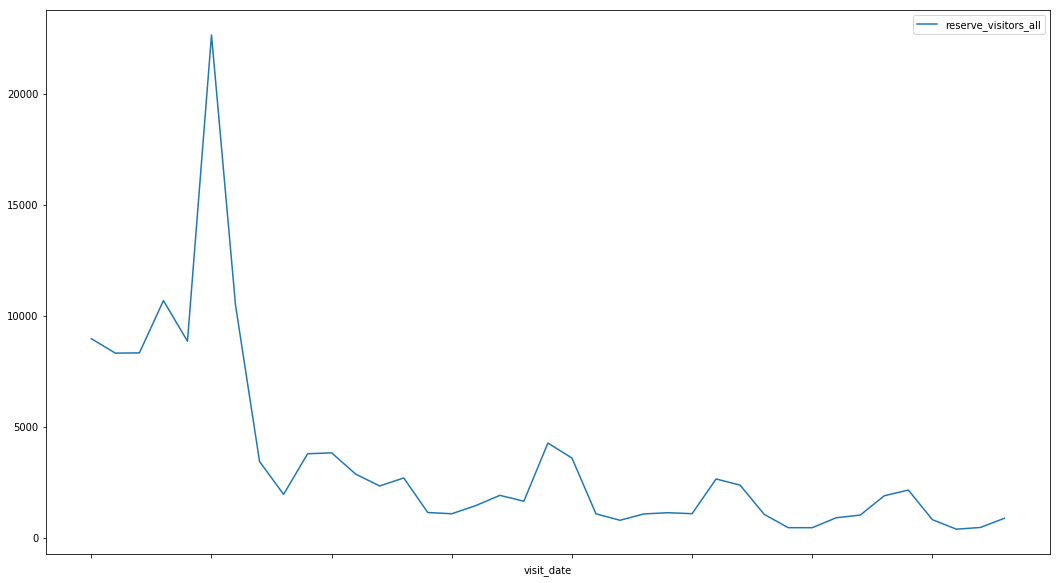

In [27]:
draw_reserve_all(data['reserve_all'])
draw_reserve_all(data['reserve_all'], pd.date_range('2017-04-23', '2017-05-31'))

### Завершаем обработку `reserve`

In [28]:
columns = ['air_store_id', 'visit_date', 'reserve_visitors', 'reserve_visitors_all', 'reserve_visitors_competitor']
data['reserve'] = data['reserve'][columns]

In [29]:
print('reserve', data['reserve'].shape)

data['reserve'].head()

reserve (428593, 5)


,air_store_id,visit_date,reserve_visitors,reserve_visitors_all,reserve_visitors_competitor
0,air_0f0cdeee6c9bf3d7,2016-01-01,0.0,62.0,62.0
1,air_7cc17a324ae5c7dc,2016-01-01,0.0,62.0,62.0
2,air_fee8dcf4d619598e,2016-01-01,0.0,62.0,62.0
3,air_a17f0778617c76e2,2016-01-01,0.0,62.0,62.0
4,air_83db5aff8f50478e,2016-01-01,0.0,105.0,105.0


In [30]:
data['reserve'].to_csv('result/reserve.csv', index=False)